Imports

In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns


Load datasets

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
train.head()

id        date country              store             product  num_sold
0   0  2010-01-01  Canada  Discount Stickers   Holographic Goose       NaN
1   1  2010-01-01  Canada  Discount Stickers              Kaggle     973.0
2   2  2010-01-01  Canada  Discount Stickers        Kaggle Tiers     906.0
3   3  2010-01-01  Canada  Discount Stickers            Kerneler     423.0
4   4  2010-01-01  Canada  Discount Stickers  Kerneler Dark Mode     491.0

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB


In [5]:
train['country'].unique()

array(['Canada', 'Finland', 'Italy', 'Kenya', 'Norway', 'Singapore'],
      dtype=object)

In [6]:
train['store'].unique()

array(['Discount Stickers', 'Stickers for Less', 'Premium Sticker Mart'],
      dtype=object)

In [8]:
train['product'].unique()

array(['Holographic Goose', 'Kaggle', 'Kaggle Tiers', 'Kerneler',
       'Kerneler Dark Mode'], dtype=object)

graphic analysis

In [9]:
def plot_individual_ts(df):
    colour_map = {"Canada": "blue", "Finland": "orange", "Italy": "green", "Kenya":"red", "Norway": "purple", "Singapore": "brown"}
    for country in df["country"].unique():
        f,axes = plt.subplots(df["store"].nunique()*df["product"].nunique(),figsize=(20,75))
        count = 0
        for store in df["store"].unique():
            for product in df["product"].unique():
                plot_df = df.loc[(df["product"] == product) & (df["country"] == country) & (df["store"] == store)]
                sns.lineplot(data = plot_df, x= "date", y="num_sold", linewidth=0.5, ax=axes[count], color=colour_map[country])
                axes[count].set_title(f"{country} - {store} - {product}")
                axes[count].axvline(pd.to_datetime("2017-01-01"), color='black', linestyle='--');
                count+=1

KeyboardInterrupt: 

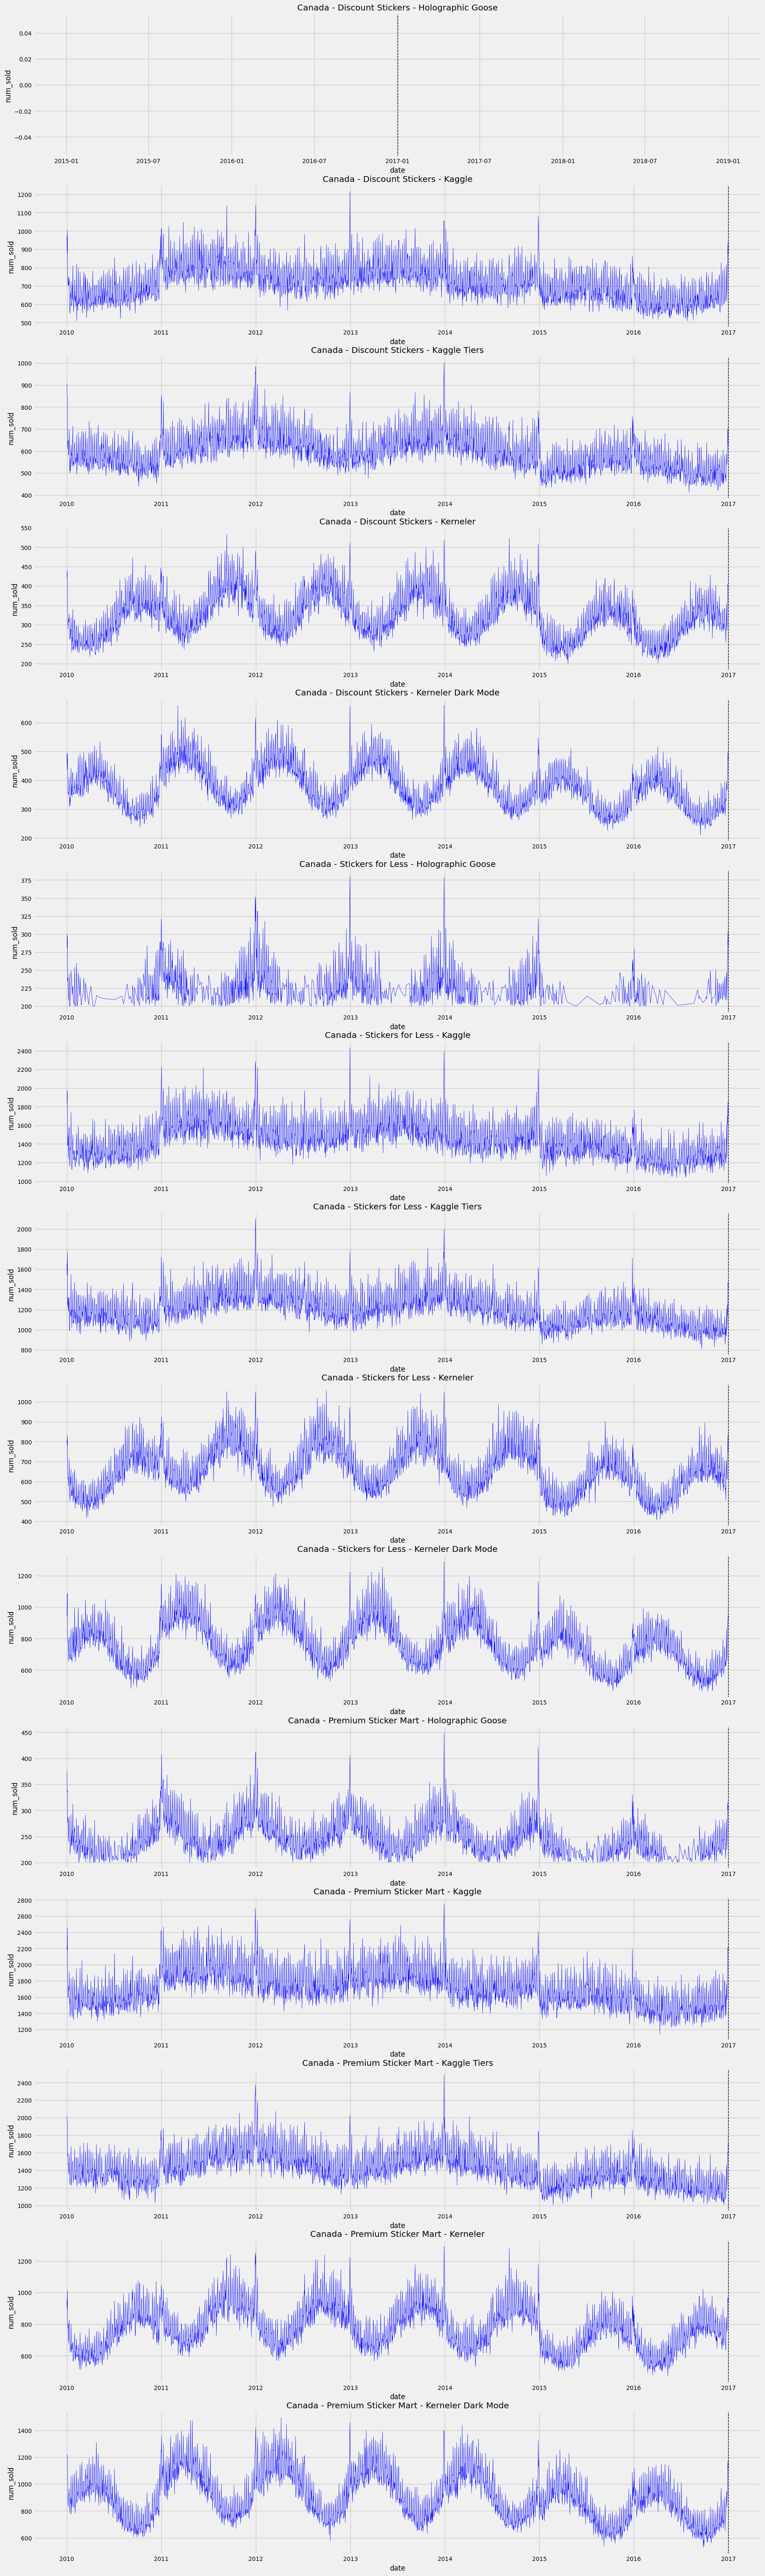

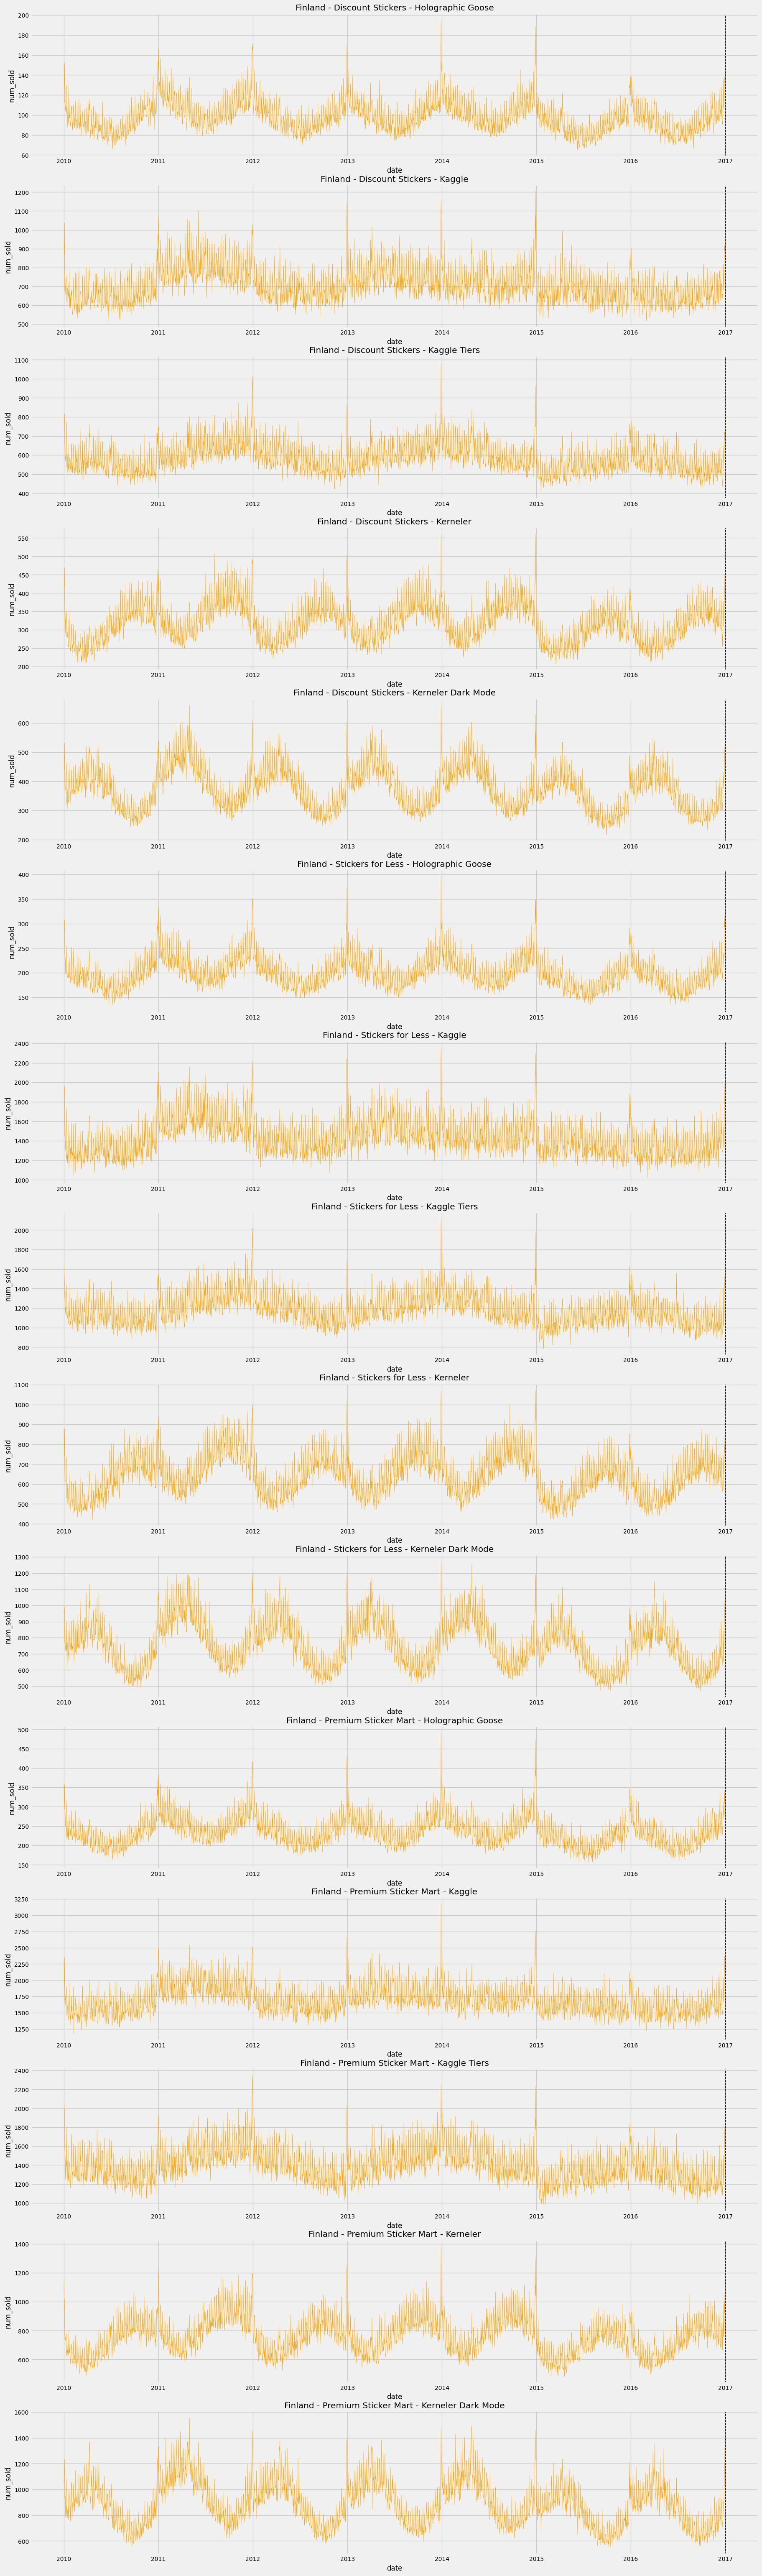

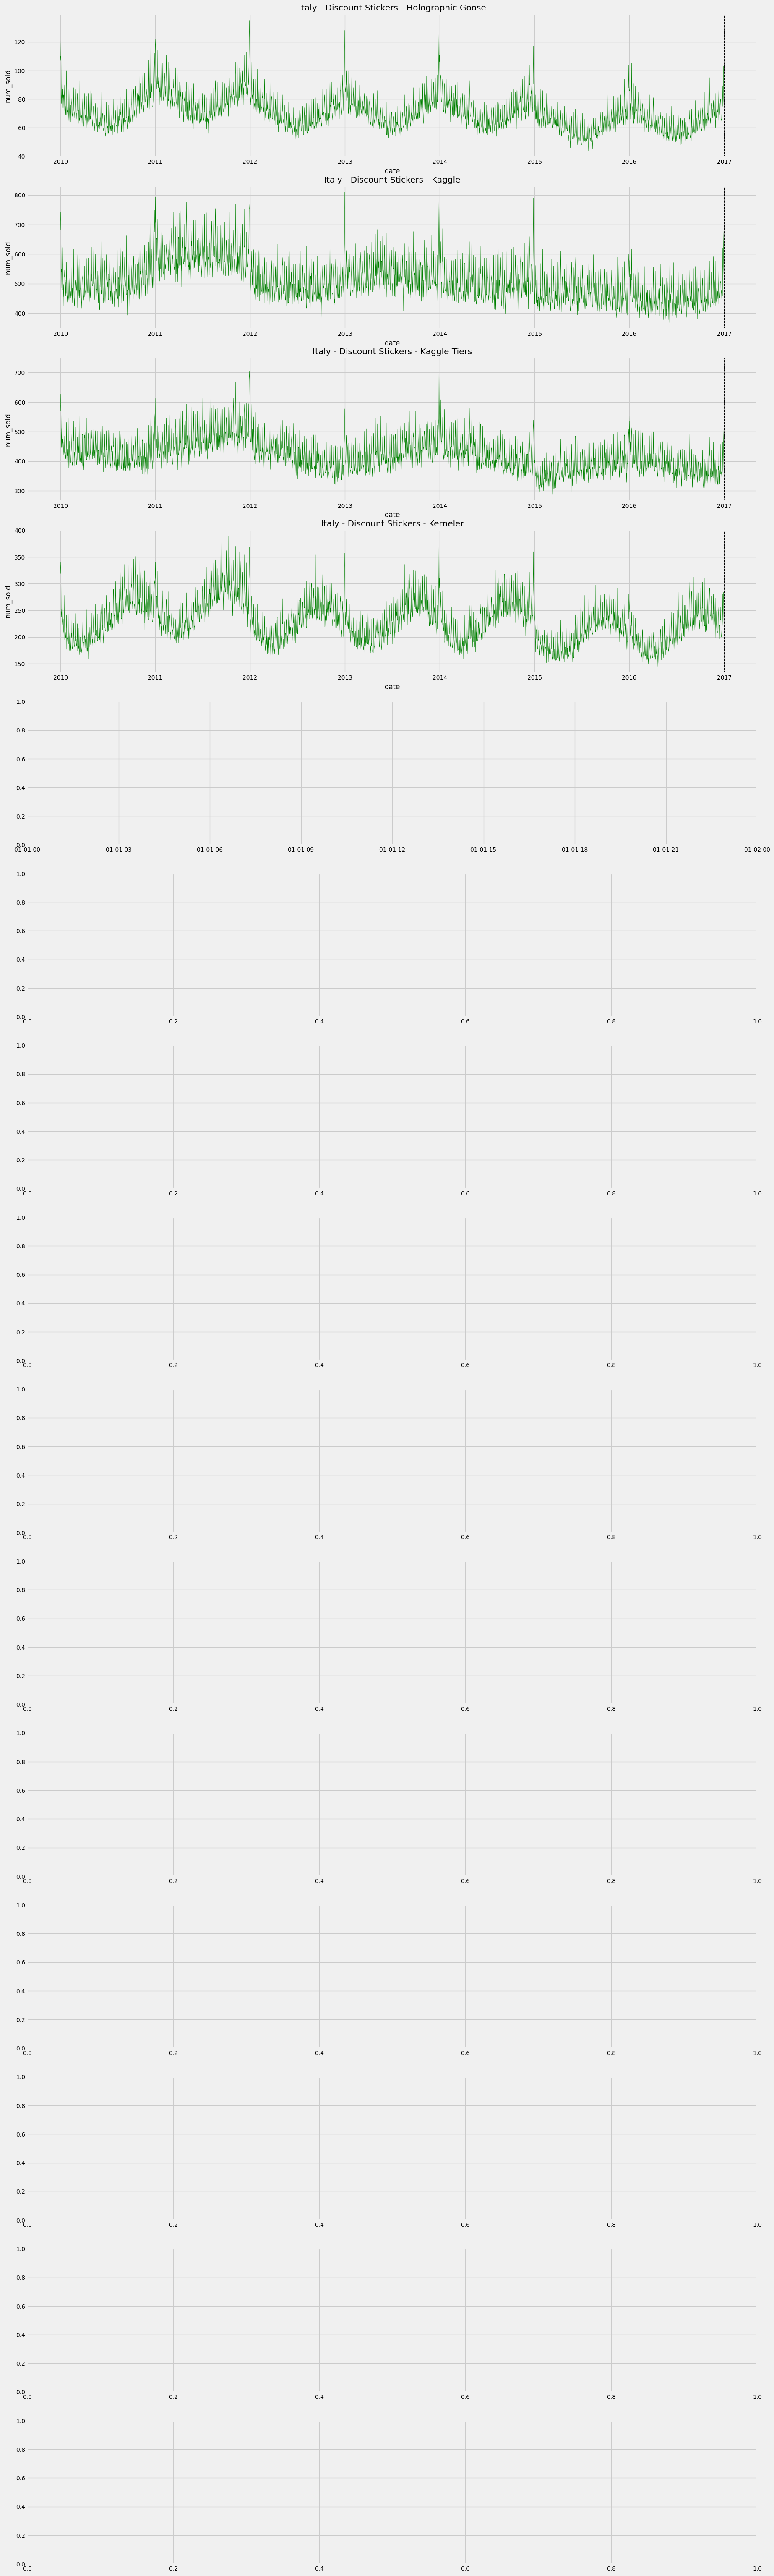

In [160]:
plot_individual_ts(train)

data preparation

set time index

In [10]:
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d')
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d')

the date is made the index as is a prerrequisite of sklearn

In [11]:
train =train.set_index('date')
test = test.set_index('date')

grouped by country, store and product and generate a dictionary containing individual dataframes, this dataframes will be grouped together to generate multiseries datasets for each product while being used individually to do the predictions. Train and test dataframes corresponding to the same set of conditions will be stored under the same key.

In [12]:
#Grouping
grouped_train = train.groupby(['country', 'store', 'product'])
grouped_test = test.groupby(['country', 'store', 'product'])

In [13]:
#Combine in a dict
combine_dict = {
        key: [group1, grouped_test.get_group(key)]
        for key, group1 in grouped_train
        if key in grouped_test.groups 
    }

Now that the index is a single continuous series of dates, we can check the integrity

In [15]:
for key in combine_dict.keys():
    combine_dict[key][0] = combine_dict[key][0].asfreq('D')
    combine_dict[key][0] = combine_dict[key][0].sort_index()
    combine_dict[key][1] = combine_dict[key][1].asfreq('D')
    combine_dict[key][1] = combine_dict[key][1].sort_index()

There are N/A for the number of stickers sold in some of the datasets, as sklearn doesn't accept N/A, they will be filled with the average of the previous and following values

In [17]:
#create a function that fills the NA
def fill_with_mean_neighbor(series):
    for i in range(len(series)):
        if pd.isna(series.iloc[i]):  # Verify whether it is NaN
            # Get previous and following value
            prev_val = series.iloc[i - 1] if i > 0 else np.nan
            next_val = series.iloc[i + 1] if i < len(series) - 1 else np.nan
            # Calculate average
            neighbors = [val for val in [prev_val, next_val] if not pd.isna(val)]
            series.iloc[i] = np.mean(neighbors) if neighbors else np.nan
    return series

In [18]:
#loop through the dictionary to isolate the series with N/A
for lst in combine_dict.values():
        for group in lst:
            if group.isnull().any(axis=1).sum() == len(group):
                group.fillna(0, inplace=True)
            elif group.isnull().any(axis=1).sum() > 0:
                group.apply(fill_with_mean_neighbor)

In [20]:
products_list= ['Holographic Goose', 'Kaggle','Kaggle Tiers', 'Kerneler Dark Mode', 'Kerneler']

In [50]:
df = process_dataframe(train, test)
df_dic = get_dic(df)
dic_sample = random.choice(list(df_dic.values()))
train_sample, test_sample = dic_sample[0], dic_sample[1]
steps = len(test_sample)
y_column = 'num_sold'

In [56]:
def group_df(grouped_dic):
    reorg_df = pd.DataFrame({'_'.join(key):df['num_sold'] for key, df in grouped_dic.items()}) 
    return reorg_df

In [57]:
train_df_dic = {key:value[0] for key,value in df_dic.items()}
dirty_arranged_df = group_df(train_df_dic)

In [58]:
clean_df_dic = dict()
for key, dataset in train_df_dic.items():
    if dataset[y_column].sum() != 0:
        clean_df_dic[key] = dataset

In [60]:
clean_arranged_df = group_df(clean_df_dic)

In [61]:
prod_clean_df_dic = dict()
for prod in products_list:
    prod_df = pd.DataFrame()
    for col in clean_arranged_df.columns:
        if prod in col:
            prod_df = pd.concat([prod_df, clean_arranged_df[col]], axis=1)
            prod_clean_df_dic[prod] = prod_df

In [68]:
from skforecast.recursive import ForecasterRecursive
from skforecast.recursive import ForecasterSarimax
from sklearn.ensemble import RandomForestRegressor
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_forecaster, grid_search_sarimax
from skforecast.sarimax import Sarimax
from skforecast.exceptions import LongTrainingWarning
from skforecast.direct import ForecasterDirect
from skforecast.recursive._forecaster_recursive_multiseries import ForecasterRecursiveMultiSeries

from sklearn.preprocessing import StandardScaler

In [69]:
def create_fit_multi_forecaster(steps, df):
    forecaster = ForecasterRecursiveMultiSeries(
                regressor          = RandomForestRegressor(random_state=123),
                lags               = steps,
                transformer_series = StandardScaler(),
                transformer_exog   = None,
                weight_func        = None,
                series_weights     = None
            )
    
    forecaster.fit(series=df)
    return forecaster

def predict_multi(steps, forecaster, level):
    prediction_level = forecaster.predict(steps=steps, levels=level)
    return prediction_level     

In [78]:
submission = pd.DataFrame()
counter = 0
for prod in products_list:
    print(prod)
    prod_dataset = prod_clean_df_dic[prod]
    forecaster = create_fit_multi_forecaster(steps, prod_dataset)
    for key, value in df_dic.items():
        level_str = '_'.join(key)
        print(level_str)
        if prod in level_str.split('_'):
            counter += 1
            print(counter)
            print(key)
            if level_str in prod_dataset.columns:
                predictions = predict_multi(steps, forecaster, level_str)
                predictions.index = value[1].index
                test_w_preds = pd.concat([value[1], predictions], axis=1).rename(columns={f'{level_str}':'num_sold'})
                #test_w_preds = pd.concat([value[1], predictions], axis=1).rename(columns={f'{level_str}':'num_sold'})
            else:
                value[1]['num_sold'] = 0
                test_w_preds = value[1]
            submission = pd.concat([submission, test_w_preds])
            display(submission)
            submission = submission.reset_index()[['id', 'num_sold']].sort_values('id')
            print(f'submission_updated for {key} multi')
submission.to_csv('sklearn_example.csv', index=False)
print('submission_saved')

Holographic Goose


c:\Users\josin\anaconda3\envs\skforecast_env\Lib\site-packages\skforecast\utils\utils.py:1167: UserWarning: Series has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


KeyboardInterrupt: 